# **U-net**

<font size = 4>U-net is an encoder-decoder architecture originally used for image segmentation. The first half of the U-net architecture is a downsampling convolutional neural network which acts as a feature extractor from input images. The other half upsamples these results and restores an image by combining results from downsampling with the upsampled images.

<font size = 4>U-net has become a commonly used architecture for image-to-image tasks and is also used in [CARE](https://www.nature.com/articles/s41592-018-0216-7).

<font size = 4>This notebook represents a basic U-net architecture which can be used by users to get acquainted with the functionality of image-to-image networks in microscopy. It should not be expected to provide results as good as networks built for specific image-to-image tasks.

---
*Disclaimer*:

This notebook is part of the Zero-Cost Deep-Learning to Enhance Microscopy project (https://github.com/HenriquesLab/DeepLearning_Collab/wiki). Jointly developed by the Jacquemet (link to https://cellmig.org/) and Henriques (https://henriqueslab.github.io/) laboratories.

This notebook is largely based on the paper: **U-Net: Convolutional Networks for Biomedical Image Segmentation** by *Olaf Ronneberger, Philipp Fischer, Thomas Brox*  (https://arxiv.org/abs/1505.04597)

And source code found in: https://github.com/zhixuhao/unet by *zhixuhao*

**Please also cite this original paper when using or developing this notebook.** 

# **How to use this notebook?**
---

###**Table of contents, Code snippets** and **Files**

On the left side of the notebook you find three tabs which contain from top to bottom the table of contents, code snippets and files

*Table of contents* = contains structure of the notebook. Click the content to move quickly between sections.

*Code snippets* = contain examples how to code certain tasks. You can ignore this when using this notebook.

*Files* = contain all available files. After mounting your google drive (see section 1.) you will find your files and folders here. 

**Remember that all uploaded files are purged after changing the runtime.** All files saved in Google Drive will remain. You do not need to use the Mount Drive-button; your Google Drive is connected in section 1.2.

**Note:** The "sample data" in "Files" contains default files. Do not upload anything here!

---
###**Text** and **Code Cells**

**Text cells** provide information and can be modified by douple-clicking the cell. You are currently reading the text cell. You can create a new text by clicking `+ Text`.

**Code cells** contain code and the code can be modfied by selecting the cell. To execute the cell, move your cursor on the `[ ]`-mark on the left side of the cell (play button appear). Click to execute the cell. After execution is done the animation of play button stops. You can create a new coding cell by clicking `+ Code`.

---
###**Making changes to the notebook**

**Please make a copy** of the notebook and save it to your Google Drive if you make changes. To do this click file -> save a copy in drive.

To **edit a cell**, double click on the text. This will show you either the source code (in code cells) or the source text (in text cells).
It is advisable to use the `#`-mark in code cells. This allows you to keep the original code piece in the cell as a comment.

**For example:**

Original code: all lines are excuted

`my_files = 2`

`my_mask = "names of masks"`

Modified code: the 1st line is not executed, but the 2nd and 3rd line are.

`#my_files = 2`

`my_files = 200`

`my_mask = "names of masks"`

# **0. Before getting started**
---

<font size = 4>

1. Create folders in the following format and upload them into your google drive:**
*   **drive**
    - source
      - img_1.tif, img_2.tif, ...
    - target
      - img_1.tif, img_2.tif, ...
    - prediction
    - prediction-groundtruth (optional)

2. Place the input images (e.g. the images you want the model to learn to segment) in the **source** folder and your desired output (e.g. segmentation maps) into the **target** folder. Corresponding **source and target images** must have the **same name**.
3. Place all your test images in the **prediction** folder.
4. If you want to compare the predicted images to the ground-truth output you can also add an additional folder containing prediction ground-truths. 

# **1. Set the Runtime type and mount your Google Drive**
---

### **1.1. Import datasets**



Go to **Runtime -> Change the Runtime type**

**Runtime type: Python 3** *(Python 3 is programming language in which this program is written)*

**Accelator: GPU** *(Graphics processing unit (GPU)*


### **1.2. Mount Google Drive**
<font size = 4> To use this notebook on your own data, you need to mount your Google Drive to this notebook.

<font size = 4> Play the below cell to mount your Google Drive and follow the link. In the new browser window, select your drive and select 'Allow', copy the code, paste into the cell and press enter.

In [1]:
#@markdown ###Mount Google Drive.

#mounts user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import shutil
shutil.copytree('/content/gdrive/My Drive/Artificial_labelling_fnet','/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/Training datasets/Artificial_labelling_fnet')

# **2. Install U-net Dependencies**
---


In [0]:
#@markdown ###Play to install U-net dependencies

#As this notebokk depends mostly on keras which runs a tensorflow backend (which in turn is pre-installed in colab)
#only the data library needs to be additionally installed.

#We enforce the keras==2.2.5 release to ensure that the notebook continues working even if keras is updated.

!pip install keras==2.2.5
!pip install data

from keras import models
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as keras
from data import *
from __future__ import print_function
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans
from skimage import img_as_ubyte

# **3. Select your parameters and paths**

---

<font size = 5> **Select paths for training, predictions and results**

<font size = 4>**`base_directory`**: To enter the path of the folder containing the training datasets (source and target), go to your files (bottom of left-hand column), navigate to the folder containing the required folder and copy the path by right-clicking on the folder and pasting into the box below.

<font size = 4>**`target_folder`, `input_folder`:** When you have selected your base directory, you only need to type the names of the source and target folders

<font size = 4>**`modelname`:** Use only my_model -style, not my-model. If you want to use a previously trained model, enter the name of the pretrained model (which should be contained in the trained_model -folder after training)

<font size = 4>**`modelpath`**: Enter the path of the folder containing your new model or pretrained model.

<font size = 4>**`results`**: This is the folder where you will save your trained models and predicted data.

**Make sure the directories exist before entering them!**

<font size = 5> **Select training parameters**

<font size = 4>**`input_image_size`, `output_image_size`**: Select the dimensions of the input and output images: If a value different from size of the raw images is chosen, the images will be reshaped for training (the original data will stay intact). Using a different dimension for targets will also result in predictions with the same dimensions.

<font size = 4>**`steps`**: This number should be equivalent to the number of samples in the training set divided by the batch size, to ensure the training iterates through the entire training set. Smaller values can be tested for testing.

<font size = 4>**`epochs`**: Choose more epochs for larger training sets. Observing how much the loss reduces between epochs during training may help determine the optimal value.

<font size = 4>**`batch_size`**: This parameter describes the amount of images that are loaded into the network per step. Smaller batchsizes may improve training performance slightly but may increase training time. If the notebook crashes whle loading the dataset this can be due to a too large batch size. Decrease the number in this case.

<font size = 4>**`prediction_format`**: This will affect the type of file the network puts out in its predictions after training and does not affect performance.


In [0]:
#@markdown ###Path to training images:

base_directory = '/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/Training datasets/U-net' #@param {type:"string"}
source_folder = 'Training - Images' #@param {type:"string"}
targets_folder = 'Training - Masks' #@param {type:"string"}

#@markdown ###Path to results folder

#prediction = 'Test - Images' #@param {type:"string"}
results = '/content/gdrive/My Drive/' #@param {type:"string"}

#@markdown ###Name of the model
modelname = 'my_model_Unet' #@param {type:"string"}

#@markdown If you want to save a model after each epoch untick this box. If ticked (recommended) you will save only the model that had the best performance during training.
save_best_only = True #@param {type:"boolean"}
if save_best_only == True:
  model_checkpoint = ModelCheckpoint(results+modelname+'.hdf5', monitor='loss',verbose=1, save_best_only=True)
else:
  model_checkpoint = ModelCheckpoint(results+modelname+'.{epoch:02d}-{loss:.2f}.hdf5', monitor='loss', verbose=1, save_best_only=False)


#@markdown ###Training parameters

#@markdown Image sizes
input_image_size =  512#@param {type:"number"}
output_image_size =  512#@param {type:"number"}
input_colour_mode = 'grayscale'
target_colour_mode = 'grayscale'

#@markdown Number of steps, epochs and batches
steps =  50#@param {type:"number"}
epochs =  10#@param {type:"number"}
batch_size =  3#@param {type:"integer"}


#@markdown ###Format
prediction_format = '.tif' #@param [".tif",".png"]

#Here we normalize the input images and adjust the values of the mask to clearly demarcate signal from background.
def adjustData(img,mask,flag_multi_class,num_class):
    img = img / 255
    mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img,mask)

def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (output_image_size,output_image_size),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    #default save_to_dir = None
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)

def testGenerator(test_path,target_size = (output_image_size,output_image_size),flag_multi_class = False,as_gray = True):
    for filename in os.listdir(test_path):
        img = io.imread(os.path.join(test_path,filename),as_gray = as_gray)
        img = img/255
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img

def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        io.imsave(os.path.join(save_path,"predicted_"+str(i)+prediction_format),img_as_ubyte(item))

**3.1. Network Hyperparameters**
---

<font size = 4> **`pooling_steps`**: Choosing a different number of pooling layers can affect the performance of the network. Each additional pooling step will also two additional convolutions. The network can learn more complex information but is also more likely to overfit. Achieving best performance may require testing different values here.

<font size = 4>**`loss_function`**: Training performance depends strongly on the loss function. To find out more about losses, see: https://keras.io/losses/.

In [0]:
pooling_steps = 2 #@param [1,2,3,4]{type:"raw"}
loss_function = 'binary_crossentropy' #@param ["binary_crossentropy", "mean_squared_error", "mean_absolute_error"] {type:"string"}

#This is code outlines the architecture of U-net. The choice of pooling steps decides the depth of the network. 
def unet(pretrained_weights = None,input_size = (input_image_size,input_image_size,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
#Downsampling steps
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    
    if pooling_steps > 1:
      pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
      conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
      conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)

      if pooling_steps > 2:
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
        drop4 = Dropout(0.5)(conv4)
      
        if pooling_steps > 3:
          pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
          conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
          conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
          drop5 = Dropout(0.5)(conv5)

#Upsampling steps

          up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
          merge6 = concatenate([drop4,up6], axis = 3)
          conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
          conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
          
    if pooling_steps > 2:
      up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
      if pooling_steps > 3:
        up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
      merge7 = concatenate([conv3,up7], axis = 3)
      conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
      
    if pooling_steps > 1:
      up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv3))
      if pooling_steps > 2:
        up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
      merge8 = concatenate([conv2,up8], axis = 3)
      conv8 = Conv2D(128, 3, activation= 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    
    if pooling_steps == 1:
      up9 = Conv2D(64, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
    else:
      up9 = Conv2D(64, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8)) #activation = 'relu'
    
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(merge9) #activation = 'relu'

#You can add to or reduce the number of convolution layers, 
#but make sure the output dimensions of one layer match the input dimensions of the next.
    
    #conv9 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(conv9) #activation = 'relu'
    #conv9 = Conv2D(2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv9) #activation = 'relu'
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = loss_function, metrics = ['acc'])
    
    print(model.summary())

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

**3.2. Data Augmentation**
---

<font size = 4> Data augmentation can improve training progress by amplifying differences in the dataset. This can be useful if the available dataset is small as without augmentation a network could quickly learn every example in the dataset. Augmentation is not necessary for training and if the dataset is large the values can be set to 0.

In [0]:
#@markdown ##Augmentation Options
#@markdown **Shift images on the horizontal axis** (0.1 is equivalent to 10%):
width_shift_range =  0.1#@param {type:"number"}
#@markdown **Shift images on the vertical axis** (0.1 is equivalent to 10%):
height_shift_range =  0.1#@param {type:"number"}

#@markdown **Rotate image within angle range (degrees):**
rotation_range =  90#@param {type:"number"}
#@markdown **Enlargen fields of view of images:**
zoom_range =  0.2#@param {type:"number"}
#@markdown **Choose shearing range:**
shear_range =  0.2#@param {type:"number"}
#@markdown **Horizontal Flip:**
horizontal_flip = True #@param {type:"boolean"}
#@markdown **Vertical Flip:**
vertical_flip = False #@param {type:"boolean"}

#given behind the # are the default values for each parameter.

data_gen_args = dict(width_shift_range=width_shift_range,#0.1
                     height_shift_range=height_shift_range,#0.1
                     rotation_range=rotation_range, #90
                     zoom_range=zoom_range,
                     shear_range=shear_range,
                     horizontal_flip=horizontal_flip,
                     vertical_flip=vertical_flip,
                     fill_mode='nearest') #0.2)

# **4. Train U-net**
---
####**Troubleshooting:** If you receive a time-out or exhausted error, try reducing the batchsize of your training set. This reduces the amount of data loaded into the model at one point in time. 

In [0]:
#@markdown ##**Start Training**
Generator = trainGenerator(batch_size, base_directory, source_folder, targets_folder, data_gen_args, save_to_dir = None)
model = unet()
model.fit_generator(Generator,steps_per_epoch=steps,epochs=epochs,callbacks=[model_checkpoint], shuffle=True)

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_166 (Conv2D)             (None, 512, 512, 64) 640         input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_167 (Conv2D)             (None, 512, 512, 64) 36928       conv2d_166[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_31 (MaxPooling2D) (None, 256, 256, 64) 0           conv2d_167[0][0]                 
___________________________________________________________________________________________

# **5. Prediction**
---
<font size = 4> In this section a trained model can be used for prediction. If you want to continue with model you trained above enter the same values. If you want to use a different previously trained model change the paths of **prediction**, **results** and the **modelname** as needed.

<font size = 4>**Select paths and model for prediction**

<font size = 4>**`prediction`:** Enter the path of the folder containing the images you want to use your trained model on. These images should be 'unseen', i.e. not part of the training dataset.

<font size = 4>**`ground_truth_exists`:** If you have ground-truth images which you want to use as reference for inspection, select "yes" from the dropdown and then enter the path in **`prediction_ground_truth`:**. *Note: the ground-truth images should have the same filenames as the images you are using for inference.*

**If you simply want to use the model for inference without a ground-truth select "no" and contine with the results path.**

<font size = 4>**`results`:**  Choose your preferred location for saving the predicted files. By default this will be the content folder which allows viewing the files instead of saving to drive. Change this to save to your drive folder.

<font size = 4>**`modelname`:** Choose the name of the saved model that you want to use for the prediction of data.

<font size = 4> **Troubleshooting:** If there is a low contrast image warning when saving the images, this may be due to overfitting of the model to the data. It may result in images containing only a single colour. Train the network again with different network hyperparameters.

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_210 (Conv2D)             (None, 512, 512, 64) 640         input_20[0][0]                   
__________________________________________________________________________________________________
conv2d_211 (Conv2D)             (None, 512, 512, 64) 36928       conv2d_210[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_39 (MaxPooling2D) (None, 256, 256, 64) 0           conv2d_211[0][0]                 
___________________________________________________________________________________________

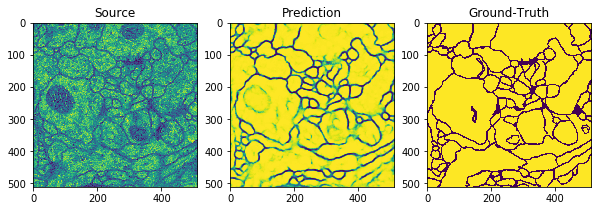

In [0]:
import matplotlib.pyplot as plt
import random
from PIL import Image

prediction_sources = '/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/Training datasets/U-net/Test - Images' #@param {type:"string"}


#@markdown Do you have a folder containing GT images as reference for the predictions (default: no)?
ground_truth_exists = "no" #@param ["no","yes"]

#@markdown If yes, enter the path of the folder with the ground-truth images.
prediction_ground_truth = '/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/Training datasets/U-net/Test - Masks' #@param {type:"string"}


results = '/content/' #@param {type:"string"}

modelname = 'my_model_Unet' #@param {type:"string"}

testGen = testGenerator(prediction_sources)

#load the trained model
os.chdir(results)
model = unet()
model.load_weights(modelname+".hdf5")

#Create a list of validation sources
source_dir_list = os.listdir(prediction_sources)
num = len(source_dir_list)

#Here, we create the predictions from the inputs and save them to the results folder

predictions = model.predict_generator(testGen, num, verbose=1)
saveResult(results,predictions)


#Fetch a random validation source and corresponding model prediction

os.chdir(prediction_sources)
random_choice = random.randint(0,num-1)
random_sample = os.path.join(prediction_sources,source_dir_list[random_choice])

#This is the prediction source image
I = plt.imread(random_sample)

#This is the predicted image from the trained model
J = plt.imread(os.path.join(results,'predicted_'+str(random_choice)+prediction_format))

#If ground-truth exists, fetch the corresponding image from the ground-truth folder

if ground_truth_exists=="yes":
  target_dir_list = os.listdir(prediction_ground_truth)
  val = os.path.join(prediction_ground_truth, target_dir_list[random_choice])
  K = plt.imread(val)

#Display validation source, prediction and (if applies) ground-truth

  f=plt.figure(figsize=(10,20))
  plt.subplot(1,3,1)
  plt.imshow(I, interpolation='nearest')
  plt.title('Source')

  plt.subplot(1,3,2)
  plt.imshow(J, interpolation='nearest')
  plt.title('Prediction')

  plt.subplot(1,3,3)
  plt.imshow(K, interpolation='nearest')
  plt.title('Ground-Truth')

else:
  f=plt.figure(figsize=(10,20))
  plt.subplot(1,2,1)
  plt.imshow(I, interpolation='nearest')
  plt.title('Source')

  plt.subplot(1,2,2)
  plt.imshow(J, interpolation='nearest')
  plt.title('Prediction')